In [2]:
import numpy as np
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Subset
import tqdm
from importlib import reload
import matplotlib.pyplot as plt
from matplotlib import ticker

import utils.mm_mnist
from utils.noise import GMMNoise
import dgcca.dgcca
import dgcca.anomaly_detection

## Load datasets

In [2]:
ds_train = utils.mm_mnist.MM_MNIST('../data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

ds_test = utils.mm_mnist.MM_MNIST('../data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

split = [50000, 10000]

ds_train_cca = Subset(ds_train, range(0, split[0]))
ds_train_ad = Subset(ds_train, range(split[0], split[0] + split[1]))

In [3]:
batch_size=128
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_train_cca = torch.utils.data.DataLoader(ds_train_cca, batch_size=batch_size, shuffle=True)
dl_train_ad = torch.utils.data.DataLoader(ds_train_ad, batch_size=len(ds_train_ad), shuffle=False) # No shuffle as corrupt and clean data must be loaded in the same order
dl_test_classifier = torch.utils.data.DataLoader(ds_test, batch_size=batch_size)
dl_test_ad = torch.utils.data.DataLoader(ds_test, batch_size=len(ds_test))

## Train or load MM-MNIST classifier

In [4]:
classifier = utils.mm_mnist.MM_Classifier(4, (1,14,14), dropout=0.2, moddrop=0, activation=torch.tanh)
criterion = nn.CrossEntropyLoss()

In [5]:
classifier.train()

epochs = 60
lr=1e-4
optimiser = torch.optim.Adam(classifier.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5, amsgrad=False)

criterion = nn.CrossEntropyLoss()
losses = []
with tqdm.auto.tqdm(total=epochs) as pbar:
    for epoch in range(epochs):
        total_loss = 0
        for batch, (data, label) in enumerate(dl_train):
            optimiser.zero_grad()
            out = classifier(data)
            loss = criterion(out, label)
            total_loss += loss
            total_loss_avg = total_loss / ((batch + 1))
            loss.backward()
            optimiser.step()
            pbar.set_description('Epoch: {:3}/{} | Error: {:.4f}'.format(epoch+1, epochs, total_loss_avg))
        pbar.update(1)
        losses.append(total_loss/len(dl_train))


Epoch:  60/60 | Error: 0.0238: 100%|██████████| 60/60 [25:09<00:00, 25.16s/it]


In [6]:
torch.save(classifier.state_dict(), 'output/mm_mnist.pth')

In [9]:
classifier = utils.mm_mnist.MM_Classifier(4, (1,14,14), dropout=0.2, moddrop=0, activation=torch.tanh)
classifier.load_state_dict(torch.load('output/mm_mnist.pth'))

<All keys matched successfully>

In [7]:
def eval_classifier(loader=dl_test_classifier):
    classifier.eval()

    correct = 0
    with tqdm.auto.tqdm(total=len(loader)) as pbar:
        total_loss = 0
        for batch, (data, label) in enumerate(loader):
            out = classifier(data).detach()
            loss = criterion(out, label)
            total_loss += loss
            total_loss_avg = total_loss / ((batch + 1))
            pred = np.argmax(out, axis=1)
            correct += np.sum((pred==label).numpy().astype(int))
            pbar.update(1)
            pbar.set_description('Accuracy: {:.2%} | Error: {:.4f}'.format(correct/((batch+1)*batch_size), total_loss_avg))
    acc = correct/len(ds_test)

In [8]:
eval_classifier()

Accuracy: 97.31% | Error: 0.0463: 100%|██████████| 79/79 [00:03<00:00, 19.93it/s]


## Train DGCCA 

In [9]:
def embed(loader=dl_train_cca, noise=None):
    classifier.eval()

    with tqdm.auto.tqdm(total=len(loader)) as pbar:
        pbar.set_description('Embedding')
        out = []
        for batch, (data, _) in enumerate(loader):
            data = data if noise is None else torch.Tensor(noise(data))
            out.append([mod.detach() for mod in classifier(data, heads=True)])
            pbar.update(1)
    output = []
    for i in range(4):
        output.append(np.concatenate([batch[i] for batch in out]))
    return output

In [10]:
train_cca_embeddings = [torch.DoubleTensor(mod) for mod in embed(dl_train_cca)] # Get pre-fusion representation for each modality

Embedding: 100%|██████████| 391/391 [00:20<00:00, 19.08it/s]


In [12]:
cca = dgcca.dgcca.DGCCA([[125, 64]]*4, 32, device='cpu', use_all_singular_values=False)

In [18]:
cca.train(train_cca_embeddings, epochs=50, batch_size=128, cca_dim=10, cca_hidden_dim=1000)

Embedding training set:: 100%|██████████| 391/391 [00:01<00:00, 302.85it/s]
Decomposed data matrix for view 0
Decomposed data matrix for view 1
Decomposed data matrix for view 2
Decomposed data matrix for view 3
Decomposed M_tilde / solved for G
Solved for U in view 0
Solved for U in view 1
Solved for U in view 2
Solved for U in view 3


In [19]:
#cca.save_checkpoint('output/mm_mnist_cca.pth')

In [13]:
cca.load_checkpoint('output/mm_mnist_cca.pth')
cca.train(train_cca_embeddings, epochs=50, batch_size=128, cca_dim=20, cca_hidden_dim=1000)

Embedding training set:: 100%|██████████| 391/391 [00:01<00:00, 312.88it/s]
Decomposed data matrix for view 0
Decomposed data matrix for view 1
Decomposed data matrix for view 2
Decomposed data matrix for view 3
Decomposed M_tilde / solved for G
Solved for U in view 0
Solved for U in view 1
Solved for U in view 2
Solved for U in view 3


## Embed clean and corrupted data

In [14]:
snr = 1

clean = [torch.DoubleTensor(mod) for mod in embed(dl_train_ad)]

if not 'noise_gen' in locals():
    noise_gen = utils.noise.GMMNoise(dl_train_ad, 5) # Train GMM for each pixel to generate noise

noise = lambda data: noise_gen.add_noise([mod.numpy() for mod in data], snr=snr) # noise and image weighted equally
corrupt = [torch.DoubleTensor(mod) for mod in embed(dl_train_ad, noise)]

Embedding: 100%|██████████| 1/1 [00:05<00:00,  5.32s/it]


In [29]:
clean_embed = cca.get_all_embeddings(clean)
corrupt_embed = cca.get_all_embeddings(corrupt)

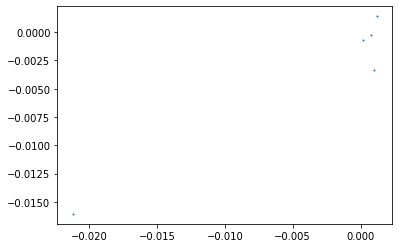

In [31]:
plt.scatter(clean_embed[0][50:55:,1], clean_embed[1][50:55,1], s=1)
plt.show()

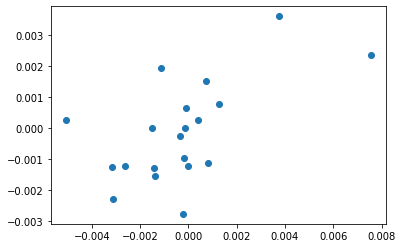

In [36]:
plt.scatter(clean_embed[0][5], corrupt_embed[1][5])
plt.show()

## Correlation between CCA dimensions for a single sample

In [28]:
def avgcorr(num, ds1, ds2):
    sums = []
    for i in range(num):
        for j in range(4):
            for k in range(4):
                sums.append(np.corrcoef(ds1[j][i], ds2[k][i])[0,1])
    return sums

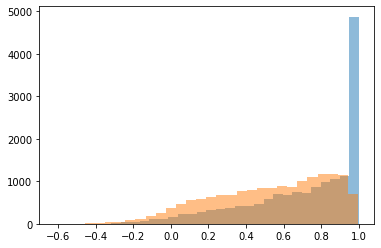

In [35]:
clean_corr = avgcorr(1000, clean_embed, clean_embed)
corrupt_corr = avgcorr(1000, clean_embed, corrupt_embed)
plt.hist(clean_corr, bins=30, alpha=0.5)
plt.hist(corrupt_corr, bins=30, alpha=0.5)
plt.show()

In [65]:
clean_corr

(0.6708902106821886, 0.27952636240033635)

In [133]:
def show(image):
    full_image = np.zeros((28,28))
    full_image[0:14,0:14] = image[0]
    full_image[0:14,14:] = image[1]
    full_image[14:,0:14] = image[2]
    full_image[14:,14:] = image[3]
    plt.imshow(full_image, cmap='gray')

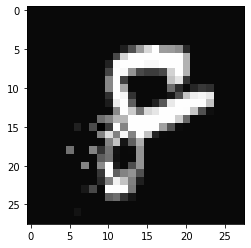

In [72]:
show([mod[0,:,:] for mod in corrupted])

## Train anomaly detector

In [15]:
window_size = 20

In [32]:
reload(dgcca.anomaly_detection)

<module 'dgcca.anomaly_detection' from 'c:\\Users\\harry\\Documents\\Work\\Dissertation\\robust-mm\\dgcca\\anomaly_detection.py'>

Getting data embeddings...
Getting noise embeddings...
Computing (2,3) threshold: 100%|██████████| 6/6.0 [00:14<00:00,  2.42s/it]


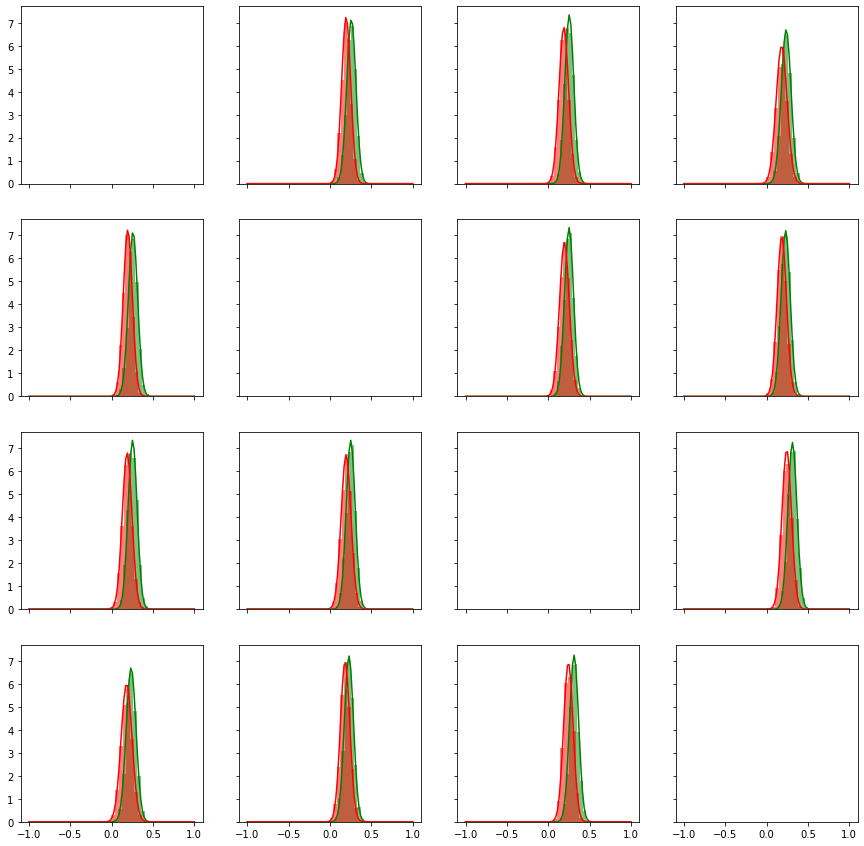

In [22]:
detector = dgcca.anomaly_detection.CcaAnomalyDetector(cca)

fig = detector.train(clean, corrupt, stride='auto', window=window_size, plot=True)

In [73]:
reload(utils.mm_mnist)

<module 'utils.mm_mnist' from 'c:\\Users\\harry\\Documents\\Work\\Dissertation\\robust-mm\\utils\\mm_mnist.py'>

In [23]:
detector.type_1

array([[0.        , 0.28893722, 0.25607283, 0.28467627],
       [0.        , 0.        , 0.27718961, 0.32564413],
       [0.        , 0.        , 0.        , 0.25751703],
       [0.        , 0.        , 0.        , 0.        ]])

In [24]:
detector.type_2

array([[0.        , 0.28146137, 0.29995361, 0.37568077],
       [0.        , 0.        , 0.34105853, 0.35594826],
       [0.        , 0.        , 0.        , 0.28160108],
       [0.        , 0.        , 0.        , 0.        ]])

In [46]:
corrupted = not_noisy
corrupted[2] = noisy[2]
corrupted = classifier(torch.tensor(corrupted).float(), heads=True).detach().double()
corrupted = [corrupted[:,i:i+125] for i in range(0,500,125)]

In [47]:
cca.get_corrs(corrupted)

array([[1.        , 0.4510529 , 0.20802458, 0.40594784],
       [0.4510529 , 1.        , 0.24619234, 0.52536565],
       [0.20802458, 0.24619234, 1.        , 0.26502792],
       [0.40594784, 0.52536565, 0.26502792, 1.        ]])

In [49]:
corrupted[0].shape

torch.Size([10000, 125])

In [55]:
def eval(data, detector, noise, num_corrupt=0, window=20, grace=0):
    classifier.eval()
    tp_pred, tn_pred, fp_pred, fn_pred, tp_ind, tn_ind, fp_ind, fn_ind = (0,0,0,0,0,0,0,0)
    with tqdm.auto.tqdm(total=len(range(0, len(data[0])-window, window))) as pbar:
        for i in range(0, len(data[0])-window, window):
            clean = np.ones(len(data))
            corrupt = np.random.default_rng().choice(len(data), size=num_corrupt, replace=False)
            clean[corrupt] = 0
            corrupt_data = noise([mod.numpy() for mod in data], corrupt)
            corrupt_data = [torch.FloatTensor(mod) for mod in corrupt_data]

            embedding = classifier(corrupt_data, heads=True)

            pred, individual = detector.detect_anomalies([mod[i:i+window,:].double() for mod in embedding], grace=grace, evaluating=True)

            for j in range(0,4):
                for k in range(j+1,4):
                    if j in corrupt or k in corrupt:
                        if not individual[j,k]:
                            tn_ind += 1
                        else:
                            fp_ind += 1
                    else:
                        if individual[j,k]:
                            tp_ind += 1
                        else:
                            fn_ind += 1
                        
            tp_pred += ((clean == pred) & (pred == True)).sum()
            tn_pred += ((clean == pred) & (pred == False)).sum()
            fp_pred += ((clean != pred) & (pred == True)).sum()
            fn_pred += ((clean != pred) & (pred == False)).sum()

            pbar.update(1)
            pbar.set_description('Prediction accuracy: {:.2%} | Individual accuracy: {:.2%} '.format((tp_pred+tn_pred)/(4*(1+(i/window))), (tp_ind+tn_ind)/(6*(1+(i/window)))))
    return np.array([[tp_pred, tn_pred, fp_pred, fn_pred],
                     [tp_ind, tn_ind, fp_ind, fn_ind]])

In [172]:
for data, label in dl_test_ad:
    data = [mod.numpy() for mod in data]
    eval(data, 1, window_size, 1)

Accuracy: 94.49% | Precision: 0.96 | Recall: 0.97: 100%|██████████| 499/499 [03:24<00:00,  2.44it/s](1445, 441, 58, 52)



In [173]:
for data, label in dl_test_ad:
    data = [mod.numpy() for mod in data]
    eval(data, 2, window_size, 0)

Accuracy: 85.62% | Precision: 0.79 | Recall: 0.97: 100%|██████████| 499/499 [06:20<00:00,  1.31it/s](970, 739, 259, 28)



In [174]:
for data, label in dl_test_ad:
    data = [mod.numpy() for mod in data]
    eval(data, 2, window_size, 1)

Accuracy: 86.12% | Precision: 0.79 | Recall: 0.98: 100%|██████████| 499/499 [06:13<00:00,  1.34it/s](978, 741, 257, 20)



In [175]:
for data, label in dl_test_ad:
    data = [mod.numpy() for mod in data]
    eval(data, 3, window_size, 0)

Accuracy: 32.62% | Precision: 0.26 | Recall: 0.90: 100%|██████████| 499/499 [08:44<00:00,  1.05s/it](448, 203, 1294, 51)



In [54]:
noise_gen = utils.noise.GMMNoise(dl_train_ad, 5)

Generating GMM for dataset: 100%|██████████| 4/4 [00:59<00:00, 14.79s/it]


In [57]:
def pipeline(classifier, cca_dim, snr, gmm_components, window_size, grace, noise_gen=None):
    classifier.eval()
    cca = dgcca.dgcca.DGCCA([[125, 64]]*4, 32, device='cpu', use_all_singular_values=False)
    cca.load_checkpoint('output/mm_mnist_cca.pth')
    train_cca_embeddings = [torch.DoubleTensor(mod) for mod in embed(dl_train_cca)]
    cca.train(train_cca_embeddings, epochs=50, batch_size=128, cca_dim=cca_dim, cca_hidden_dim=1000)

    clean = [torch.DoubleTensor(mod) for mod in embed(dl_train_ad)]

    if noise_gen is None:
        noise_gen = utils.noise.GMMNoise(dl_train_ad, gmm_components) # Train GMM for each pixel to generate noise

    noise = lambda data: noise_gen.add_noise([mod.numpy() for mod in data], snr=snr) # noise and image weighted equally
    corrupt = [torch.DoubleTensor(mod) for mod in embed(dl_train_ad, noise)]

    detector = dgcca.anomaly_detection.CcaAnomalyDetector(cca)
    detector.train(clean, corrupt, stride='auto', window=window_size)

    test_noise = lambda data, modality: noise_gen.add_noise(data, snr=snr, modality=modality)

    res = []
    for data, label in dl_test_ad:
        data = [mod.double() for mod in data]
        for num_corrupt in [1]:
            res = eval(data, detector, test_noise, num_corrupt, window_size, grace)
    
    return res

In [60]:
classifier = utils.mm_mnist.MM_Classifier(4, (1,14,14), dropout=0.2, moddrop=0, activation=torch.tanh)
classifier.load_state_dict(torch.load('output/mm_mnist.pth'))

results = []
for dims in [5,10,20,40,60]:
    dim_results = []
    for window_size in [5,10,20,50,100]:
        print('======= dims: {} | window_size: {} ======='.format(dims, window_size))
        dim_results.append(pipeline(classifier, cca_dim=dims, snr=1, gmm_components=5, window_size=window_size, grace=0, noise_gen=noise_gen))
    results.append(dim_results)

00:04<00:00,  4.39s/it]
Getting data embeddings...
Getting noise embeddings...
Computing (2,3) threshold: 100%|██████████| 6/6.0 [00:08<00:00,  1.47s/it]
Prediction accuracy: 70.84% | Individual accuracy: 61.49% : 100%|██████████| 499/499 [03:19<00:00,  2.50it/s]
Embedding training set:: 100%|██████████| 391/391 [00:01<00:00, 282.45it/s]
Decomposed data matrix for view 0
Decomposed data matrix for view 1
Decomposed data matrix for view 2
Decomposed data matrix for view 3
Decomposed M_tilde / solved for G
Solved for U in view 0
Solved for U in view 1
Embedding:   0%|          | 0/1 [00:00<?, ?it/s]Solved for U in view 2
Solved for U in view 3
Embedding: 100%|██████████| 1/1 [00:05<00:00,  5.50s/it]
  0%|          | 0/6.0 [00:00<?, ?it/s]Getting data embeddings...
Getting noise embeddings...
Computing (2,3) threshold: 100%|██████████| 6/6.0 [00:12<00:00,  2.02s/it]
Prediction accuracy: 79.90% | Individual accuracy: 70.35% : 100%|██████████| 199/199 [01:24<00:00,  2.36it/s]
Embedding trai

In [21]:
for batch_size in [128]:
    for snr in [1.0]:
        for gmm_components in [5]:
            dims = []
            for window_size in [3,5,10,15,20,30,50,100,500]:
                windows = []
                for cca_dim in [5,10,15,20,30,50]:
                    for grace in [0]:
                        with open('output/{}_{}_{}_{}_{}_{}.npy'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace), 'rb') as f:
                            windows.append(np.load(f))
                dims.append(np.stack(windows))


In [22]:
results = dims

In [5]:
def acc(raw, dim, corr, lines):
    res = []
    for i in range(len(lines)):
        res.append((raw[i][corr,dim,0]+raw[i][corr,dim,1])/np.sum(raw[i][corr,dim,:]))
    return res

In [6]:
def acc_window(res, window_idx, dim, corr, xs):
    data = [window[window_idx] for window in res]
    results = []
    for i in range(len(xs)):
        results.append((data[i][corr,dim,0]+data[i][corr,dim,1])/np.sum(data[i][corr,dim,:]))
    return results

In [8]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    dims = [5,10,15,20,30,50]
    for dim in range(len(dims)):
        ax[ax_idx].plot(range(len([3,5,10,15,20,30,50,100,500])), acc(results[dim], 0, ax_idx, [5,10,15,20,30,50]))
    ax[ax_idx].legend([5,10,15,20,30,50])
    ax[ax_idx].set_xticklabels([0,3,5,10,15,20,30,50,100,500])
    ax[ax_idx].set_xlabel('Number of samples')
    ax[ax_idx].set_ylabel('Accuracy')
#fig.title('Overall modality corruption detection accuracy over varying CCA dimension')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (9,) and (6,)

<ipython-input-179-e1e8d7259f9f>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[ax_idx].set_xticklabels([0,5,10,15,20,30,50])


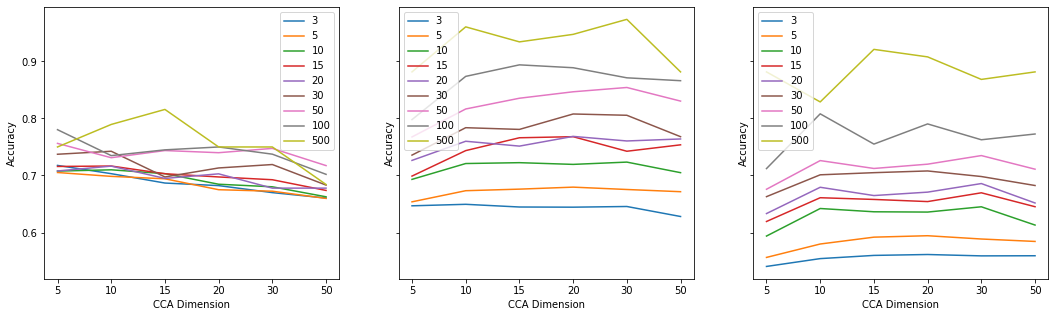

In [179]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    windows = [3,5,10,15,20,30,50,100,500]
    for window in range(len(windows)):
        ax[ax_idx].plot(range(len([5,10,15,20,30,50])), acc_window(results, window, 0, ax_idx))
    ax[ax_idx].legend(windows)
    ax[ax_idx].set_xticklabels([0,5,10,15,20,30,50])
    ax[ax_idx].set_xlabel('CCA Dimension')
    ax[ax_idx].set_ylabel('Accuracy')
    #ax.set_title('Overall modality corruption detection accuracy over varying CCA dimension')
plt.show()

<ipython-input-180-c64719d35923>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[ax_idx].set_xticklabels([0,3,5,10,15,20,30,50,100,500])


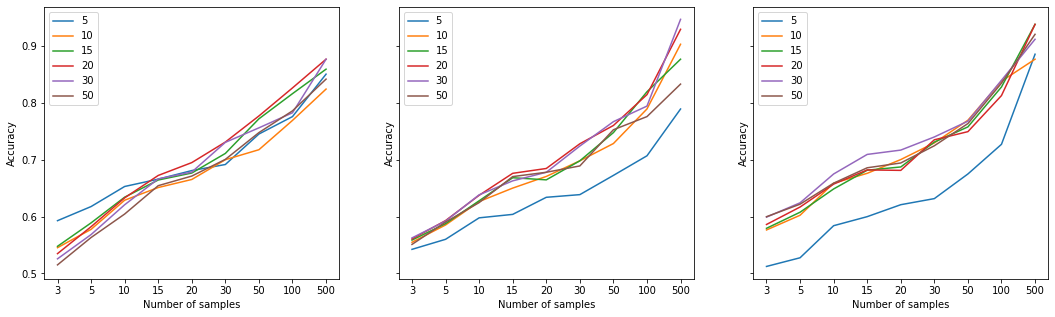

In [180]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    dims = [5,10,15,20,30,50]
    for dim in range(len(dims)):
        ax[ax_idx].plot(range(len([3,5,10,15,20,30,50,100,500])), acc(results[dim], 1, ax_idx))
    ax[ax_idx].legend([5,10,15,20,30,50])
    ax[ax_idx].set_xticklabels([0,3,5,10,15,20,30,50,100,500])
    ax[ax_idx].set_xlabel('Number of samples')
    ax[ax_idx].set_ylabel('Accuracy')
#fig.title('Overall modality corruption detection accuracy over varying CCA dimension')
plt.show()

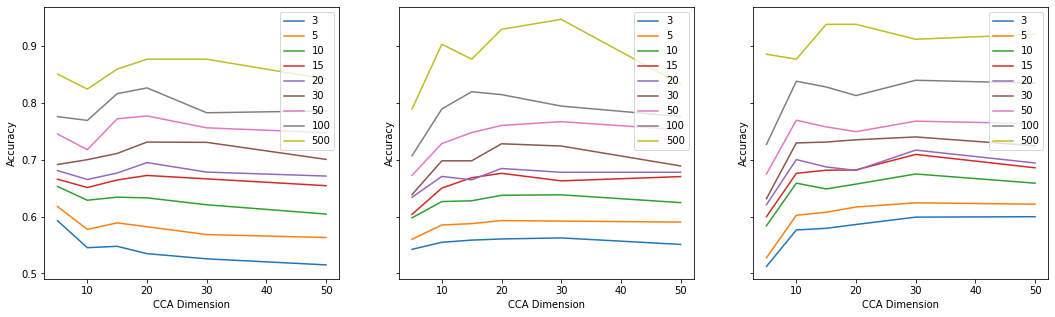

In [176]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    windows = [3,5,10,15,20,30,50,100,500]
    for window in range(len(windows)):
        ax[ax_idx].plot([5,10,15,20,30,50], acc_window(results, window, 1, ax_idx))
    ax[ax_idx].legend(windows)
    ax[ax_idx].set_xlabel('CCA Dimension')
    ax[ax_idx].set_ylabel('Accuracy')
    #ax.set_title('Overall modality corruption detection accuracy over varying CCA dimension')
plt.show()

In [ ]:
first_window = [3,5,10,15,20,30,50,100,500]
first_dim = [5,10,15,20,30,50]

In [26]:
for batch_size in [128]:
    noise = []
    for snr in [0.0,0.25,0.5,0.75,1.0,2.0]:
        gmm = []
        for gmm_components in [1,3,5,7,9]:
            for cca_dim in [15]:
                for window_size in [30]:
                    for grace in [0]:
                        with open('output/{}_{}_{}_{}_{}_{}.npy'.format(batch_size, snr, gmm_components, cca_dim, window_size, grace), 'rb') as f:
                            gmm.append(np.load(f))
        noise.append(np.stack(gmm))
results = noise

In [190]:
len(results)

6

<ipython-input-14-823d9af2c993>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[ax_idx].set_xticklabels([0,1,' ',3,' ',5,' ',7,' ',9])


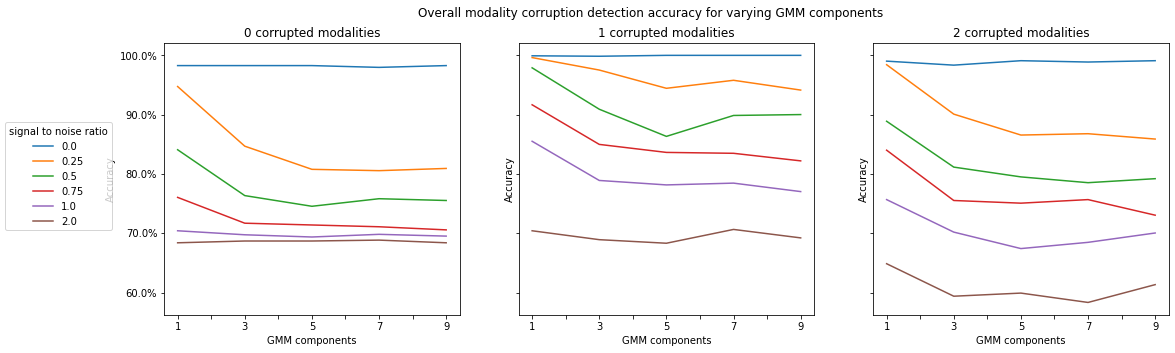

In [14]:
lines = [0.0,0.25,0.5,0.75,1.0,2.0]
xs = [1,3,5,7,9]

fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    for snr in range(len(lines)):
        ax[ax_idx].plot(xs, [100*el for el in acc(results[snr], 0, ax_idx, xs)])
    ax[ax_idx].yaxis.set_major_formatter(ticker.PercentFormatter())
    ax[ax_idx].set_xlabel('GMM components')
    ax[ax_idx].set_ylabel('Accuracy')
    ax[ax_idx].set_xticklabels([0,1,' ',3,' ',5,' ',7,' ',9])
    ax[ax_idx].set_title('{} corrupted modalities'.format(ax_idx))

fig.legend(lines, title='signal to noise ratio', loc='center left')
fig.suptitle('Overall modality corruption detection accuracy for varying GMM components')
plt.show()

In [29]:
def plots(results, lines, xs, xlabel, ylabel, legend, title):
    fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
    for ax_idx in range(3):
        for line in range(len(lines)):
            ax[ax_idx].plot(xs, [100*el for el in acc(results[line], 0, ax_idx, xs)])
        ax[ax_idx].yaxis.set_major_formatter(ticker.PercentFormatter())
        ax[ax_idx].set_xlabel(xlabel)
        ax[ax_idx].set_ylabel(ylabel)
        ax[ax_idx].set_xticklabels([0,1,' ',3,' ',5,' ',7,' ',9])
        ax[ax_idx].set_title('{} corrupted modalities'.format(ax_idx))

    fig.legend(lines, title=legend, loc='center left')
    fig.suptitle(title)
    plt.show()

<ipython-input-29-6067c4b9164a>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[ax_idx].set_xticklabels([0,1,' ',3,' ',5,' ',7,' ',9])


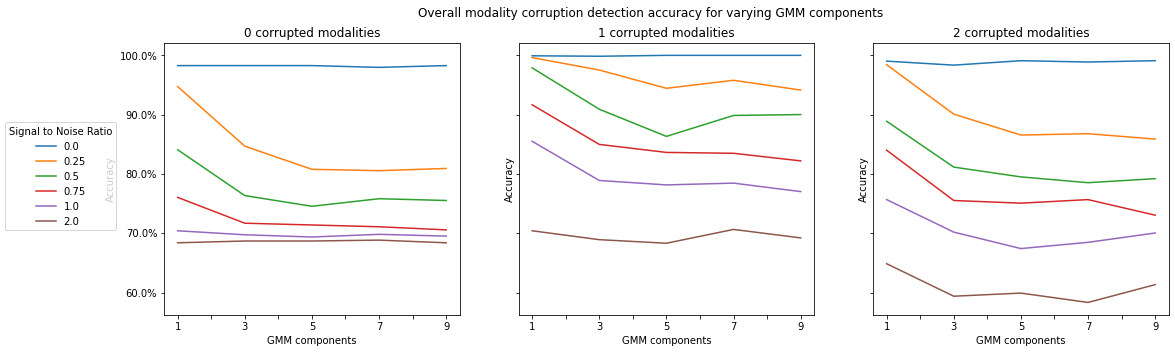

In [30]:
plots(results, [0.0,0.25,0.5,0.75,1.0,2.0], [1,3,5,7,9], 'GMM components', 'Accuracy', 'Signal to Noise Ratio', 'Overall modality corruption detection accuracy for varying GMM components')

In [9]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(18, 5))
for ax_idx in range(3):
    windows = [3,5,10,15,20,30,50,100,500]
    for window in range(len(windows)):
        ax[ax_idx].plot(range(len([5,10,15,20,30,50])), acc_window(results, window, 0, ax_idx))
    ax[ax_idx].legend(windows)
    ax[ax_idx].set_xticklabels([0,5,10,15,20,30,50])
    ax[ax_idx].set_xlabel('CCA Dimension')
    ax[ax_idx].set_ylabel('Accuracy')
ax[1].set_title('Overall modality corruption detection accuracy over varying CCA dimension')
plt.show()

TypeError: acc_window() missing 1 required positional argument: 'xs'